In [32]:
!pip install -U finance-datareader

Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.9.10)


In [33]:
import pandas as pd
import pandas_datareader as pdr
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
import time
import random
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [34]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [35]:
'''import FinanceDataReader as fdr

# 한국거래소 상장종목 전체
df_krx = fdr.StockListing('KRX')
df_krx.head()'''

"import FinanceDataReader as fdr\n\n# 한국거래소 상장종목 전체\ndf_krx = fdr.StockListing('KRX')\ndf_krx.head()"

In [67]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)
        self.scaler = MinMaxScaler()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)#주식 6가지 특징, 고,시,저,종,거,변
        '''
        df_gold = pdr.DataReader('GOLDAMGBD228NLBM', 'fred', start=self.start, end=self.end)#금값
        df_du = pdr.DataReader('POILDUBUSDM', 'fred', start=self.start, end=self.end)#석유
        #df_kospi = fdr.DataReader('KS11', self.start, self.end)#코스피

        #df_dollar = fdr.DataReader('USD/KRW', self.start, self.end)#원달러환율

        #gold 채우기
        df_gold = df_gold.fillna(value=-1)
        gold = []
        for i in df_gold.values:
            gold.append(i[0])

        check = min(gold)
        for i in range(0,len(gold)):
            if gold[i] == -1:
                gold[i] = check
            else:
                check = gold[i]
        
        #oil 채우기
        du = df_du.values
        ddu = []
        check = int(list(start)[1])
        c = 0
        for i in self.data.index:
            if i.month == check:
                ddu.append(du[c][0])
            else:
                check += 1
                if check >= 13:
                    check = 1
                c += 1
                if c >= len(du):
                    break
                ddu.append(du[c][0])
        
        #self.data['dollar'] = df_dollar[['Close']]

        #self.data['kospi'] = df_kospi[['Close']]
        self.data['oil'] = pd.DataFrame(data=ddu, index=self.data.index, columns=['oil'])
        self.data['gold'] = pd.DataFrame(data=gold, index=df_gold.index, columns=['gold'])
        '''
        print('len:',len(self.data.index))
        self.data = pd.DataFrame(self.scaler.fit_transform(self.data))
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[[0, 1, 2, 3, 4]]
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [68]:
class GRU(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(GRU, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn
        self.gru = nn.GRU(self.input_dim, self.hidden_dim*2, self.num_layers)
        self.gru2 = nn.GRU(self.hidden_dim*2, self.hidden_dim, self.num_layers)
        self.regressor = self.make_regressor()

    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim//2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim//2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        x, _ = self.gru(x)
        x, _ = self.gru2(x)
        y_pred = self.regressor(x[-1].view(self.batch_size, -1))
        return y_pred

In [69]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [70]:
# ====== Random Seed Initialization ====== #
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'


# ====== Model Capacity ===== #
args.input_dim = 5
args.hid_dim = 64
args.n_layers = 2

args.use_bn =True
args.batch_size = 128
args.x_frames = 7
args.y_frames = 7
args.dropout = 0.5


In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

# cj 대한 통운 000120, CJ 001040, LG이노텍 011070, GS 078930, 두산 중공업 034020 KT '030200'
test_symbol = ['000120','001040','011070','078930','034020','030200']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [76]:
best_model = GRU(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
best_model.load_state_dict(torch.load('/content/gdrive/My Drive/GRUmodel/GRU_5_model.pt'))
best_model.to(args.device)

GRU(
  (gru): GRU(5, 128, num_layers=2)
  (gru2): GRU(128, 64, num_layers=2)
  (regressor): Sequential(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [77]:


for symbol in test_symbol:
    testinput = StockDataset(symbol,args.x_frames,args.y_frames,(2011,1,1),(2020,8,1))
    testloader = DataLoader(testinput, batch_size=args.batch_size, shuffle=False, drop_last=True)

    print(len(testloader))

    mae = 0
    length = 0

    result = []
    result3 = []
    for i, (X,y) in enumerate(testloader):

        best_model.eval()
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)

        y_pred = best_model(X)
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        mae += metric(y_true,y_pred)
        length += 1
        y_pred = y_pred.cpu().detach().numpy()
        result.extend(y_true)
        result3.extend(y_pred)


    mae = mae/length
    print(mae)

len: 2361
18
[4.8610797]
len: 2361
18
[3.0357046]
len: 2361
18
[5.014606]
len: 2361
18
[3.4575474]
len: 2361
18
[2.6647298]
len: 2361
18
[3.5242302]


Text(0.5, 1.0, 'pred vs real')

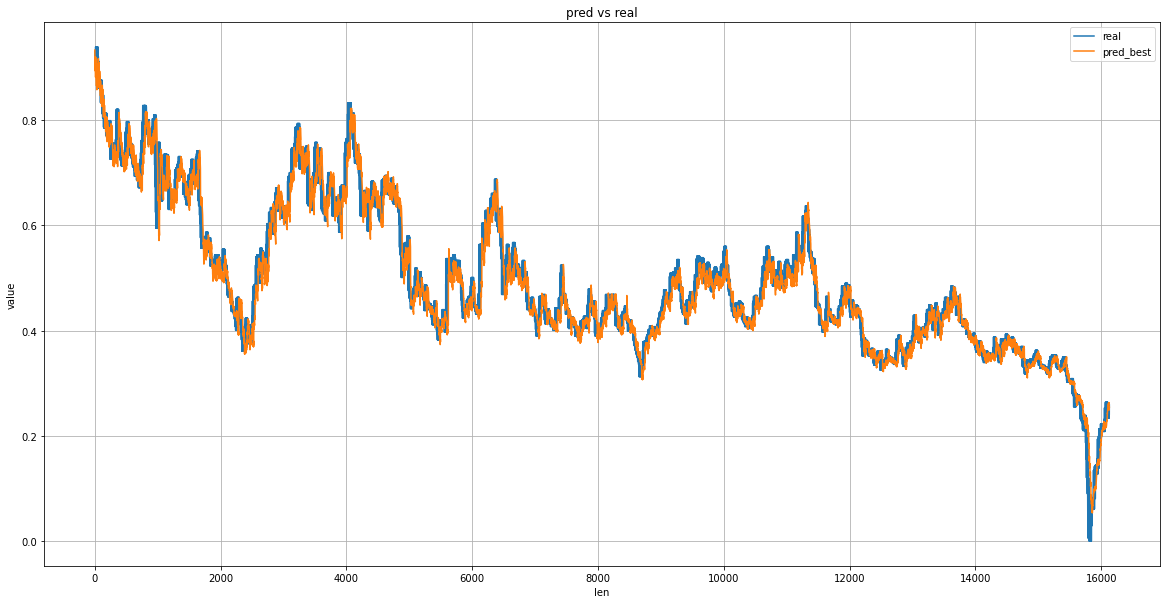

In [78]:
fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(result)+1)]


# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, result,  label='real')
ax.plot(xl, result3,  label='pred_best')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')

In [79]:
'''
from google.colab import drive
drive.mount('/content/gdrive')

modelPath = '/content/gdrive/My Drive/GRU_batch_128_model.pt'
torch.save(model.state_dict(), modelPath)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n\nmodelPath = '/content/gdrive/My Drive/GRU_batch_128_model.pt'\ntorch.save(model.state_dict(), modelPath)\n"